# Data Processing
### (skip to below for charts and discussion)

In [101]:
import os
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import display
from mp_learning import snake_data
import matplotlib
import numpy as np
import mpld3
from mpld3 import fig_to_html, plugins

# mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# HELPER FUNCTIONS
# 1 - Calculate slope of points, input: 1x91 snake state array
def slope ( points, m="no_debug" ):
    X, Y = [], []
    x_tail = points[78]
    y_tail = points[79]
    for i in range(0,7):
        X.append(points[i*13] - x_tail)
        Y.append(points[(i*13)+1] - y_tail)
#     X = np.asarray(X).reshape((1,7))
#     Y = np.asarray(Y).reshape((1,7))
    if (m == "debug"):
        print "X: ",X
        print "Y: ",Y
#     s_x = np.std(X)
#     s_y = np.std(Y)
#     XY = np.concatenate((X, Y), axis=0)
#     corr_x_y = np.corrcoef(XY)
#     slope = corr_x_y[0,1]*(s_y / s_x)
    weights = [2.0,1.5,1.0,0.5,1.0,1.0,0.0]
    slope = np.dot(np.multiply(weights,X),np.multiply(weights,Y))/np.sum(np.square(np.multiply(weights,X)))
#     y_bar = np.mean(Y)
#     x_bar = np.mean(X)
#     intercept = y_bar - slope * x_bar
    quadrant = 0
    point = []
    if (X[0] > 0.0) and (slope >= 0.0):
        quadrant = 1
        point = [1, slope]
    elif (X[0] < 0.0) and (slope < 0.0):
        quadrant = 2
        point = [-1, -slope]
    elif (X[0] < 0.0) and (slope >= 0.0):
        quadrant = 3
        point = [-1, -slope]
    elif (X[0] > 0.0) and (slope < 0.0):
        quadrant = 4
        point = [1, slope]
    else:
        raise ValueError("Invalid slope/quadrant computation")
    if (m == "debug"):
        print "quad: ", quadrant
#         print "y_bar: ", y_bar
        print "slope: ", slope
        point1 = [10, 10*slope]
        point2 = [-10, -10*slope]
        plot_snake_state_pts(X,Y, point1, point2)
    return point, quadrant

def scatter3d(x, title1, y, title2, z, title3, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(10,6))
    ax = Axes3D(fig)
    ax.scatter(x, y, z)
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    ax.set_xlabel(title1)
    ax.set_ylabel(title2)
    ax.set_zlabel(title3)
    plt.show()
    
def plot_snake_state ( state ):
    pts = []
    for i in range(0,7):
        pts.append(state[i*13:i*13+2])
    pts = np.asarray(pts)

    fig = plt.figure()
    plt.scatter(pts[:,0], pts[:,1])
#     y_min = np.min(pts[:,1])
#     x_min = np.min(pts[:,0])
#     y_max = np.max(pts[:,1])
#     x_max = np.max(pts[:,0])
    plt.ylim([-40,40])
    plt.xlim([-40,40])
    plt.show()
    
def get_snake_xy ( state ):
    pts = []
    for i in range(0,7):
        pts.append(state[i*13:i*13+2])
    pts = np.asarray(pts)
    return pts
    
def plot_snake_state_pts ( points_x, points_y, pt1, pt2):
#     pts = np.asarray(np.concatenate((points_x,points_y),axis=1)
    fig = plt.figure()
    ax = fig.gca()
    plt.scatter(np.asarray(points_x), np.asarray(points_y))
    plt.ylim([-25,25])
    plt.xlim([-25,25])
    ax.set_xticks(np.arange(-25,25,5))
    ax.set_yticks(np.arange(-25,25,5))
    
    ax.plot([pt1[0], pt2[0]],[pt1[1], pt2[1]], "r--")
    
    plt.grid()
    plt.show()
    
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


FILEHOME = os.path.abspath(os.path.curdir)
datapath = FILEHOME + '/data/cpg_output_2s_2.txt'

model = snake_data.Model(datapath, 'snake')

# DATA CLEANING AND THRESHOLDING FOR ANALYSIS
# 1 - Remove |ang_vel(z-axis head_link)| > 5.0
ang_vel_thresh = (model.end_states[:,12]> -5.0) & (model.end_states[:,12]< 5.0)
model.end_states = model.end_states[ang_vel_thresh]
model.start_states = model.start_states[ang_vel_thresh]
model.controls = model.controls[ang_vel_thresh]

# 2 - Remove displacement(sqrt(dx^2+dy^2) middle link) < 3.0
disp_thresh = np.sqrt(np.square(model.end_states[:,39] - model.start_states[:,39]) + 
                 np.square(model.end_states[:,40] - model.start_states[:,40])) > 3.0
model.end_states = model.end_states[disp_thresh]
model.start_states = model.start_states[disp_thresh]
model.controls = model.controls[disp_thresh]

# 3 - New dimensions of data:
print model.start_states.shape
print model.end_states.shape

# 1 - Figure out linear regression of link locations for slope of result
slope_start, start_quadrant = slope( model.start_states[0,:])
# print slope_start
model.delta_angles = []
for i in range(0, model.end_states.shape[0]):
    slp, quad = slope(model.end_states[i,:])
    angle = angle_between(slope_start, slp)*180/np.pi
    if (quad == 3) or (quad == 4):
        angle = angle*-1
    model.delta_angles.append(angle)
model.delta_angles = np.asarray(model.delta_angles)

# 2 - Calc displacement angle and store
# 3 - Calc total displacement
model.disp_angles = []
model.disp = []
start_vec = np.asarray([model.start_states[0,39] - model.start_states[0,78], 
                          model.start_states[0,40] - model.start_states[0,79]])
start_disp = np.asarray(model.start_states[0,39:41])
for i in range(0,model.end_states.shape[0]):
    end_vec = np.asarray([model.end_states[i,39] - model.end_states[i,78], 
                              model.end_states[i,40] - model.end_states[i,79]])
    end_disp = np.asarray(model.end_states[i,39:41])
    disp_total = np.sqrt(np.sum(np.square(start_disp - end_disp)))
    disp = angle_between(start_vec, end_vec)*180/np.pi
    if (model.end_states[i,40] < model.start_states[0,40]):
        disp = disp * -1
#     print i, ": ", disp_total
    model.disp_angles.append(disp)
    model.disp.append(disp_total)
model.disp_angles = np.asarray(model.disp_angles)
model.disp = np.asarray(model.disp)


(1774, 9)
(1774, 4)
(574, 91)
(574, 91)


# Analysis
Note: All below analysis has been performed over random sampling of four parameter values 

$$\textrm{freq, phase_offset, Ampl_left, Ampl_right} <=> (\nu,\delta\phi, \alpha_l, \alpha_r)$$

Where our goal is to find parameter settings which maximize displacement in "useful" directions, e.g. -45$^\circ$, 0$^\circ$, 45$^\circ$.

Above calculations give us:
* **heading change**: calculated as rotation (around z-axis) of linear interpolation of snake's configuration from start to end of applying the parameterized control sequence for 10s
* **displacement angle**: again calculated around z-axis, this is the angle between origin & snake's middle link from $t_{start} = 0s$ and $t_{end} = 10s$
* **total displacement**: this is the L2 distance between the middle link from start to end

### 1 - Plotting distribution of heading changes
Here, we just expect/want to see that we have a good variety of heading changes for the snake's configuration so that we can choose from a variety of "gaits" to use in SST/iSST

In [102]:
# Histogram with modified axes/grid
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111, axisbg='#EEEEEE')
ax.grid(color='white', linestyle='solid')

bins = np.linspace(-200,200,80)
_ = ax.hist(model.delta_angles, bins, histtype='stepfilled', fc='lightblue', alpha=0.5)
mpld3.display(fig)

### 2 - Checking for good "coverage" over parameter space
Interactive plot of all four variables in pairs, showing sample coverage of parameter space where that space is
* **frequency**: (0.1, 1.0)
* **phase offset**: (0.2, 1.0)
* **ampl left**: (0.25, 0.75)
* **ampl right**: (0.25, 0.75)

In [116]:
fig, axs = plt.subplots(2, 2, figsize=(8,8), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.3)

# cm = plt.get_cmap('jet')
# cNorm = matplotlib.colors.Normalize(vmin=min(model.disp[:]), vmax=max(model.disp[:]))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
# scalarMap.set_array(model.disp[:])

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[0].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[0].scatter(model.controls[:,0],model.controls[:,1], s=40, alpha=0.5)
axs.flat[0].set_xlabel("frequency")
axs.flat[0].set_ylabel("phase offset")

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[1].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[1].scatter(model.controls[:,0],model.controls[:,3], s=40, alpha=0.5)
axs.flat[1].set_xlabel("frequency")
axs.flat[1].set_ylabel("ampl. right")

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[2].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[2].scatter(model.controls[:,2],model.controls[:,1], s=40, alpha=0.5)
axs.flat[2].set_xlabel("ampl. left")
axs.flat[2].set_ylabel("phase offset")

# ax = fig.add_subplot(212, axisbg='#EEEEEE')
axs.flat[3].grid(color='lightgray', alpha=0.7, linestyle='solid')
points =axs.flat[3].scatter(model.controls[:,2],model.controls[:,3], s=40, alpha=0.5)
axs.flat[3].set_xlabel("ampl. left")
axs.flat[3].set_ylabel("ampl. right")

plugins.connect(fig, plugins.LinkedBrush(points))
mpld3.display(fig)

### 3 - Plotting all three measures together
In order to select which parameter values we'd like, we look first at 
1. **heading change v. displacement angle**: Where we would actually expect these to correlate, i.e, if snake rotates to the left, displacement should be in that direction as well
2. **heading change v. total displacement**: Given that the above measures of a certain parameterization are reasonably well correlated, we want to select those which maximize our total displacement of the center link so as to locomote as fast as possible

*Note: below is an interactive chart. Use interaction tools in the toolbar by hovering mouse over bottom left corner or by hovering over individual points in order to see their control parameterizations*

In [103]:
fig, axs = plt.subplots(2, 1, figsize=(8,8), sharex='col')
fig.subplots_adjust(hspace=0.3)

# cm = plt.get_cmap('jet')
# cNorm = matplotlib.colors.Normalize(vmin=min(model.disp[:]), vmax=max(model.disp[:]))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
# scalarMap.set_array(model.disp[:])

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[0].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[0].scatter(model.delta_angles[:],model.disp_angles[:], s=40, alpha=0.5, c=model.disp[:])
axs.flat[0].set_xlabel("heading change")
axs.flat[0].set_ylabel("displ. dir")

# ax = fig.add_subplot(212, axisbg='#EEEEEE')
axs.flat[1].grid(color='lightgray', alpha=0.7, linestyle='solid')
points =axs.flat[1].scatter(model.delta_angles[:],model.disp[:], s=40, alpha=0.5, c=model.disp[:])
axs.flat[1].set_xlabel("heading change")
axs.flat[1].set_ylabel("displ. magnit.")
labels = ["Control[{0}]: {1}".format(i,e) for i,e in enumerate(model.controls[:])]
tooltip = plugins.PointLabelTooltip(points, labels)

plugins.connect(fig, plugins.LinkedBrush(points))
plugins.connect(fig, tooltip)
mpld3.display(fig)

### 4 - Finding gaits which maximize displacement along chosen directions
We can easily find those parameterization which maximize our displacement along some desired set of "learned gait" locomotion directions by constraining the search such that both our displacement and heading directions (already positively correlated) both lie within some threshold of the desired direction. 

Below uses thresh=+/-5$^\circ$, and searches for 9 learned gait locomotion directions which meet that criteria and maximize displacement of the middle link.

#### Plot shows resulting configuration of snake in global frame after applying each learned gait for 10s

In [121]:
# Search for those points which maximize displacement in chosen directions
desired_directions = [-90, -67.5, -45, -22.5, 0, 22.5, 45, 67.5, 90]
max_d = [0] * len(desired_directions)
allow_thresh = 2
best_indices, best_controls = [0] * len(desired_directions), [0] * len(desired_directions)
for idx in range(0,len(desired_directions)):
    for i, pt in enumerate(model.controls):
        if ((model.disp_angles[i] > desired_directions[idx] - allow_thresh) and 
            (model.disp_angles[i] < desired_directions[idx] + allow_thresh) and 
            (model.delta_angles[i] > desired_directions[idx] - allow_thresh) and 
            (model.disp_angles[i] < desired_directions[idx] + allow_thresh)):
                if (model.disp[i] > max_d[idx]):
                    max_d[idx] = model.disp[i]
                    best_indices[idx] = i
                    best_controls[idx] = pt
for j, pt in enumerate(best_controls):
    print desired_directions[j], ": ", max_d[j], "--> controls[", best_indices[j], "]: ", pt

-90 :  7.44917 --> controls[ 265 ]:  [ 0.48363316  0.44311377  0.69843316  0.36434445]
-67.5 :  6.50717 --> controls[ 490 ]:  [ 0.39636999  0.37320879  0.70221281  0.52952147]
-45 :  5.09775 --> controls[ 537 ]:  [ 0.50436991  0.7192443   0.70231074  0.35340697]
-22.5 :  4.21996 --> controls[ 458 ]:  [ 0.28275448  0.69795316  0.69575268  0.4810614 ]
0 :  4.16452 --> controls[ 387 ]:  [ 0.86790013  0.97667652  0.36332938  0.45071948]
22.5 :  3.92915 --> controls[ 443 ]:  [ 0.41040111  0.62427992  0.29061458  0.54260862]
45 :  6.19827 --> controls[ 355 ]:  [ 0.51707113  0.45718804  0.56684291  0.68814802]
67.5 :  7.03881 --> controls[ 73 ]:  [ 0.57051837  0.59932882  0.303449    0.626571  ]
90 :  4.74019 --> controls[ 292 ]:  [ 0.68396026  0.20763725  0.60151839  0.74249327]


In [122]:
fig, ax = plt.subplots(1,1, figsize=(8,6))

for e, pt in enumerate(best_indices):
    conf = get_snake_xy(model.end_states[pt,:])
    ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="Dir:{0}".format(desired_directions[e]))
    ax.scatter(conf[0,0], conf[0,1], s=25)
    ax.scatter(conf[-1,0], conf[-1,1], s=25)
start_conf = get_snake_xy(model.start_states[0,:])
ax.scatter(start_conf[0,0], start_conf[0,1], s=25)
ax.scatter(start_conf[-1,0], start_conf[-1,1], s=25)
ax.plot(start_conf[:,0], start_conf[:,1], lw=5,alpha=0.5, label="Start")
ax.grid(color='lightgray', alpha=0.7)
ax.legend()
mpld3.display(fig)



# -------- SCRATCH WORK ---------



In [ ]:
idx = 177

plot_snake_state(model.start_states[0,:])
# print model.start_states[0,:]
# plot_snake_state(model.end_states[idx,:])
print model.start_states[0,39:42]

plot_snake_state(model.end_states[idx,:])
print model.end_states[idx,39:42]
# slope(model.end_states[idx,:], m="debug")
# print slope_start

(160, 4)
(160, 91)
(160,)


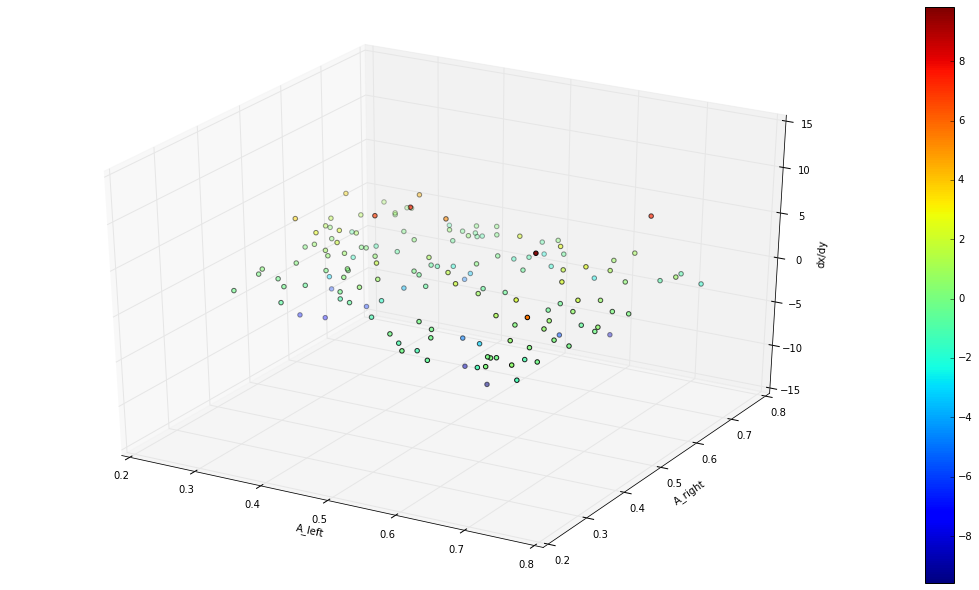

In [323]:
controls_po_25_50 = model.controls[(model.controls[:,0]>=0.25) & (model.controls[:,0]<=0.50)]
print controls_po_25_50.shape
end_states_po_25_50 = model.end_states[(model.controls[:,0]>=0.25) & (model.controls[:,0]<=0.50)]
print end_states_po_25_50.shape
dy_e = end_states_po_25_50[:,0] - end_states_po_25_50[:,26]
dx_e = end_states_po_25_50[:,1] - end_states_po_25_50[:,27]
slope = dx_e/dy_e
print slope.shape

# cm = plt.get_cmap("RdYlGn")
# fig = plt.figure()
# ax = plt.subplot(111, projection='3d')
# # c = plt.scatter(model.controls[:,2],slope, c='r')
# # plt.ylim([-15,15])
# ax.plot(controls_po_25_50[:,2],controls_po_25_50[:,3],slope, 
#         ms=2, marker='o', c=[cm(i) for i in slope/np.max(slope)] )
# ax.set_xlabel("A_left")
# ax.set_ylabel("A_right")
# # plt.zlabel("dx/dy")
# ax.set_zlabel("dx/dy")
# ax.set_zlim([-5,5])
# plt.show()

scatter3d(controls_po_25_50[:,2][(slope<10) & (slope>-10)],controls_po_25_50[:,3][(slope<10) & (slope>-10)],slope[(slope<10) & (slope>-10)], slope[(slope<10) & (slope>-10)])

Size:  (1774, 91)


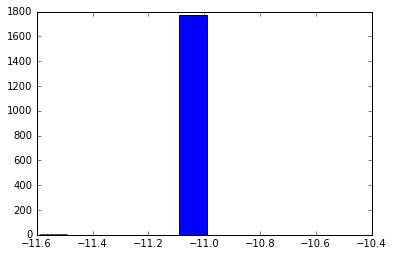

Size:  (1774, 91)


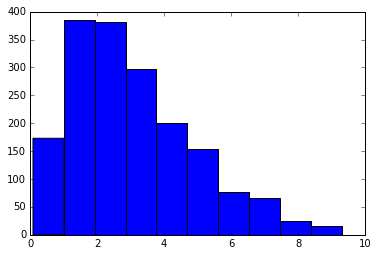

In [26]:
idx = 39

print "Size: ", model.start_states.shape
plt.figure(1)
plt.hist(model.start_states[:,idx])
plt.show()

print "Size: ", model.end_states.shape
plt.figure(2)
plt.hist(np.sqrt(np.square(model.end_states[:,idx] - model.start_states[:,idx]) + 
         np.square(model.end_states[:,idx+1] - model.start_states[:,idx+1])))
plt.show()


In [6]:
dx_e = model.end_states[:,0] - model.end_states[:,26]
dy_e = model.end_states[:,1] - model.end_states[:,27]
slope = dx_e/dy_e
print slope
plt.figure(3)
# plt.hist(slope)
bins = np.linspace(-25,25,40)
n, bins_out, plot = plt.hist(slope, 
                         bins, alpha=0.5, label="pred")
plt.show()

[ -1.39484262e+00  -8.96256685e-01  -5.18211842e-01  -5.26330233e-01
   8.17207432e+00   5.02377868e-01   4.43460315e-01  -4.99783516e-01
  -1.46111178e+00  -9.46809590e-01   8.20417166e-01   9.05434012e-01
  -1.66886353e+00   2.71270961e-01   1.77884400e-01  -5.49472094e-01
  -1.76236403e+00  -1.18169546e+00   6.87397182e-01   2.82314968e+00
  -6.11861169e-01  -3.51144820e-01   1.60206831e+00  -6.99936724e+00
  -1.00346327e+00   1.42682004e+00  -6.82294428e-01   1.10877144e+00
   2.33881998e+00   8.16292614e-02  -9.65542078e-01  -1.04503475e-01
   5.82238817e+00   1.35525549e-02  -2.57317719e+02  -4.05156434e-01
  -6.26314998e-01  -3.01153469e+00   1.07591665e+00  -9.94477940e+00
  -1.15931354e-01   4.48381233e+00  -1.72490239e+00  -2.02648711e+00
   7.38834143e-01  -1.62317634e-01  -1.67696369e+00   4.52492177e-01
  -1.40631235e+00  -3.08823490e+01   4.03257320e-03   3.93429446e+00
  -3.54464889e-01  -1.23309232e-01  -4.09583747e-01  -8.83768141e-01
   1.63140178e+00  -2.69220662e+00